## Sentiment Analysis

Objective: How well can we predict a restaurant’s Zomato score using the polarity of their reviews as input?

### Imports

In [7]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import nltk
import statistics
import random
import sys, os

#Preprocessing
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'utils')))
from pipeline import *
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from textblob import TextBlob
sent_tokenizer = PunktSentenceTokenizer()


#Vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Sentiment Analysis with VADER
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#Sentiment Analysis with TextBlob
#%pip install textblob
from textblob import TextBlob

#Classification and Metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from tqdm import tqdm


import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\renat\AppData\Roaming\nltk_data...


### Preprocessing

In [8]:
def sentiment_preproc(reviews):
    '''
    Prepares the raw reviews dataset for the sentiment analysis task
    Since the requirement is to use review polarity to predict Zomato score, the remaining columns are no longer needed for this task
    Note that we assume the Zomato score as the average of all reviews of this restaurant.
    '''
    # Drops unnecessary columns and null rows
    reviews.drop(['Reviewer', 'Metadata', 'Time', 'Pictures'], axis=1, inplace=True)
    reviews.dropna(subset=['Review', 'Rating'], inplace=True)
  
    # Converts the rating column to numeric
    reviews['Rating'] = pd.to_numeric(reviews['Rating'], errors='coerce')

    # Groups by restaurant and calculates the mean rating
    average_ratings = reviews.groupby('Restaurant')['Rating'].mean().reset_index()
    average_ratings.rename(columns={'Rating': 'Zomato Score'}, inplace=True)

    # Merges this with the original df to add the column
    reviews = reviews.merge(average_ratings, on='Restaurant', how='left')

    # Removes the unneeded restaurant column
    reviews.drop(['Restaurant', 'Rating'], axis=1, inplace=True)

    return reviews

In [10]:
# Importing the dataset, and preparing it for analysis
reviews = pd.read_csv(r'C:\Users\renat\Desktop\gitrep\Hyderabadi-Word-Soup\data_hyderabad\10k_reviews.csv')
reviews = sentiment_preproc(reviews)
reviews.sample(5)

,Review,Zomato Score
7594,good,3.740
4299,Big fan of All day Breakfast in bed? Order fro...,3.580
4497,This restaurant has its priorities straight. U...,3.190
4651,We went on the new year day. Menu was limited....,3.225
682,Taste is not good and also not freshly prepare...,3.200


In [11]:
# Creating the example class for sentiment analysis
class SA_Example():
    def __init__(self, example_row) -> None:
        self.index = example_row.index[0]
        self.score = example_row["Zomato Score"].values[0]
        self.raw_content = example_row["Review"].values[0]

In [12]:
# Store the result as an example object
reviews_row = reviews.loc[reviews["Review"] == reviews.Review.sample(1).values[0]]
reviews_example = SA_Example(reviews_row)

Since we are using VADER:
- Letter case should be preserved
- Stopwords should be preserved
- Punctuation should be preserved

In [23]:


reviews["Preproc_Review"] =\
      reviews["Review"].map(lambda content :pipeline.main_pipeline(content,
                                                                        print_output=False,
                                                                        no_stopwords=False,
                                                                        lowercase=False,
                                                                        lemmatized=False,
                                                                        no_punctuation=False
                                                                        ))

In [19]:
sent_tokenizer = PunktSentenceTokenizer()
reviews_example.tokenized_sentences = sent_tokenizer.tokenize(reviews_example.raw_content)
reviews_example.tokenized_sentences

['On weekend we were in search of restaurant to have hyderabadi dum biryani.',
 'As we entered out of office we found number of restaurants(all were busy).',
 'We found this restaurant in the third floor and thought of visiting this place becoz it is third floor and will not be much crowded but surprisingly people where waiting for seats.',
 'We ordered for chicken kebabs for starter which was perfectly cooked with awesome taste and after that we ordered chicken biryani which was came up with nice quality and superb taste with good enough quantity.',
 'By the seeing the price of biryani we got shocked and after looking at the biryani quantity surprised.',
 'Serious it was good quantity for the price.',
 'After a gap of two weeks we again visited the place have Al mandi and we order for grilled chicken mandi which of average taste.']

In [24]:
reviews["Preproc_Sentences"] =\
      reviews["Review"].map(lambda content : [pipeline.main_pipeline(sentence,
                                                                            print_output=False,
                                                                            no_stopwords=False,
                                                                            lowercase=False,
                                                                            lemmatized=False,
                                                                            no_punctuation=False
                                                                            ) for sentence in sent_tokenizer.tokenize(content)])

### VADER sentiment analyser

Testing with an example

In [25]:
vader = SentimentIntensityAnalyzer()

In [26]:
sent_compound_list = []

for sentence in reviews_example.tokenized_sentences:
    sent_polarity = vader.polarity_scores(sentence)
    sent_compound_list.append(sent_polarity["compound"])
    print("{} : \n {}".format(sentence, sent_polarity))

On weekend we were in search of restaurant to have hyderabadi dum biryani. : 
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
As we entered out of office we found number of restaurants(all were busy). : 
 {'neg': 0.0, 'neu': 0.902, 'pos': 0.098, 'compound': 0.0772}
We found this restaurant in the third floor and thought of visiting this place becoz it is third floor and will not be much crowded but surprisingly people where waiting for seats. : 
 {'neg': 0.0, 'neu': 0.917, 'pos': 0.083, 'compound': 0.4215}
We ordered for chicken kebabs for starter which was perfectly cooked with awesome taste and after that we ordered chicken biryani which was came up with nice quality and superb taste with good enough quantity. : 
 {'neg': 0.0, 'neu': 0.624, 'pos': 0.376, 'compound': 0.959}
By the seeing the price of biryani we got shocked and after looking at the biryani quantity surprised. : 
 {'neg': 0.114, 'neu': 0.792, 'pos': 0.094, 'compound': -0.1027}
Serious it was good quantity for the

In [27]:
scratch_df = pd.DataFrame({"Sentences":[sentence for sentence in reviews_example.tokenized_sentences], "Compound_Score":sent_compound_list})
scratch_df.describe()

,Compound_Score
count,7.000000
mean,0.248114
std,0.371640
min,-0.102700
25%,0.000000
50%,0.077200
75%,0.401650
max,0.959000


In [28]:
test_review_polarity = vader.polarity_scores(reviews_example.raw_content)
print(test_review_polarity)
print(reviews_example.score)

{'neg': 0.026, 'neu': 0.771, 'pos': 0.203, 'compound': 0.9866}
3.46


Applying VADER

In [29]:
def vader_wrapper(user_review):    
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(vader.polarity_scores(sentence)["compound"])
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = vader.polarity_scores(user_review)["compound"]
    return polarity

In [30]:
reviews["content_polarity_vader"] = reviews["Preproc_Review"].map(lambda review: vader_wrapper(review))
reviews["mean_sentence_polarity_vader"] = reviews["Preproc_Sentences"].map(lambda review: vader_wrapper(review))
reviews.sample(5)

,Review,Zomato Score,Preproc_Review,Preproc_Sentences,content_polarity_vader,mean_sentence_polarity_vader
2494,The place is really nice. Devashish helped us ...,3.37,The place is really nice . Devashish helped us...,"[The place is really nice., Devashish helped u...",0.9391,0.639767
3598,Nice food,3.49,Nice food,[Nice food],0.4215,0.421500
5014,Food was simply Superb.Punjabi food was very d...,3.61,Food was simply Superb.Punjabi food was very d...,[Food was simply Superb.Punjabi food was very ...,0.8930,0.893000
5044,We were 5 members and we went for lunch during...,3.61,We were 5 members and we went for lunch during...,[We were 5 members and we went for lunch durin...,0.9275,0.195120
8437,The Hotel is Full cheating we are very much di...,3.17,The Hotel is Full cheating we are very much di...,[The Hotel is Full cheating we are very much d...,-0.8672,-0.231000


Comparing Content Polarity with Mean Sentence Polarity

In [31]:
pearson_r, p_value = pearsonr(reviews["mean_sentence_polarity_vader"],reviews["content_polarity_vader"])
pearson_r

0.8198405240794107

### Using TextBlob

Testing

In [32]:
test_blob = TextBlob(reviews_example.raw_content)
test_blob.sentiment

Sentiment(polarity=0.16403508771929823, subjectivity=0.6482456140350877)

In [33]:
def textblob_wrapper(user_review):   
    if type(user_review) == list:
        sent_compound_list = []
        for sentence in user_review:
            sent_compound_list.append(TextBlob(sentence).sentiment.polarity)
        polarity = np.array(sent_compound_list).mean()
    else:
        polarity = TextBlob(user_review).sentiment.polarity
    return polarity

In [34]:
round(textblob_wrapper(reviews_example.tokenized_sentences), 5)

0.03155

Applying

In [35]:
reviews["content_polarity_textblob"] = reviews["Preproc_Review"].map(lambda review : textblob_wrapper(review))
reviews["mean_sentence_polarity_textblob"] = reviews["Preproc_Sentences"].map(lambda review : textblob_wrapper(review))

In [36]:
pearson_r, p_value = pearsonr(reviews["mean_sentence_polarity_textblob"],reviews["content_polarity_textblob"])
pearson_r

0.9547797484697194

### Comparing the SA results against the average zomato score of the restaurant

In [37]:
pearson_r, p_value = pearsonr(reviews["Zomato Score"],reviews["content_polarity_vader"])
pearson_r

0.3312539978803274

In [38]:
scaler = preprocessing.MinMaxScaler()
#The "reshape(-1,1)" is there to make sure that the column is fed as a 2D (4915 x 1) array
normalized_score = scaler.fit_transform(reviews["Zomato Score"].to_numpy().reshape(-1, 1))
normalized_polarity_vader = scaler.fit_transform(reviews["content_polarity_vader"].to_numpy().reshape(-1, 1))

#The "reshape(-1)" is there to flatten the 2D array into a 1D array
pearson_r, p_value = pearsonr(normalized_score.reshape(-1), normalized_polarity_vader.reshape(-1))
pearson_r

0.33125399788032744

In [39]:
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_vader.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1), normalized_polarity_vader.reshape(-1))
print("RMSE: {}; MAPE: {}".format(round(rmse, 3), round(mape, 3)))

RMSE: 0.39; MAPE: 20528180076598.91


In [40]:
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_vader.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1)+1, normalized_polarity_vader.reshape(-1)+1)

print("RMSE: {}; MAPE: {}".format(round(rmse, 3), round(mape, 3)))

RMSE: 0.39; MAPE: 0.238


### Summary

In [41]:
reviews["normalized_score"] = normalized_score.reshape(-1)
reviews["normalized_polarity_vader"] = normalized_polarity_vader.reshape(-1)
reviews.describe()

,Zomato Score,content_polarity_vader,mean_sentence_polarity_vader,content_polarity_textblob,mean_sentence_polarity_textblob,normalized_score,normalized_polarity_vader
count,9955.000000,9955.000000,9955.000000,9.955000e+03,9955.000000,9955.000000,9955.000000
mean,3.600263,0.475257,0.275961,2.492011e-01,0.226977,0.483977,0.736976
std,0.505936,0.585091,0.373486,3.644299e-01,0.336662,0.204007,0.293441
min,2.400000,-0.994200,-0.972100,-1.000000e+00,-1.000000,0.000000,0.000000
25%,3.230000,0.000000,0.000000,5.551115e-17,0.000000,0.334677,0.498621
50%,3.610000,0.765000,0.318200,2.750000e-01,0.233510,0.487903,0.882291
75%,3.845000,0.935900,0.503653,5.034524e-01,0.451181,0.582661,0.968002
max,4.880000,0.999700,0.995000,1.000000e+00,1.000000,1.000000,1.000000


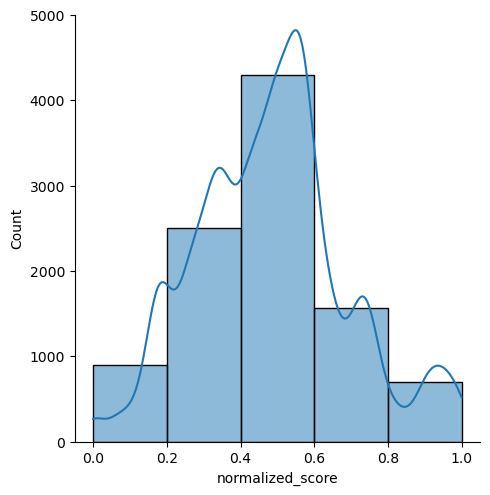

In [42]:
score_graph = sns.displot(reviews["normalized_score"], kde=True, bins=5)
plt.ylim(0, 5000)
plt.show()

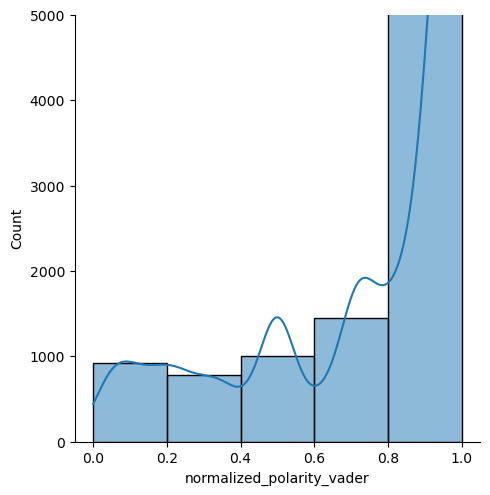

In [43]:
polarity_graph = sns.displot(reviews["normalized_polarity_vader"], kde=True, bins=5)
plt.ylim(0, 5000)
plt.show()

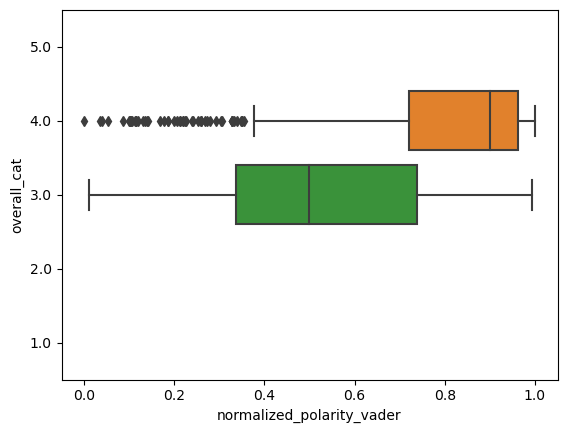

In [44]:
# Ensure the 'overall_cat' column is formatted correctly
reviews["overall_cat"] = reviews["Zomato Score"].apply(lambda score: f"{score:.1f}")

# Create the boxplot with the correct order
sns.boxplot(data=reviews, x="normalized_polarity_vader", y="overall_cat", order=["5.0", "4.0", "3.0", "2.0", "1.0"])
plt.show()

In [45]:
normalized_polarity_textblob = scaler.fit_transform(reviews["content_polarity_textblob"].to_numpy().reshape(-1, 1))
reviews["normalized_polarity_textblob"] = normalized_polarity_textblob.reshape(-1)
pearson_r, p_value = pearsonr(normalized_score.reshape(-1), normalized_polarity_textblob.reshape(-1))
rmse = mean_squared_error(normalized_score.reshape(-1), normalized_polarity_textblob.reshape(-1), squared=False)
mape = mean_absolute_percentage_error(normalized_score.reshape(-1)+1, normalized_polarity_textblob.reshape(-1)+1)

print("Pearson R: {}; RMSE: {}; MAPE: {}".format(round(pearson_r, 3), round(rmse, 3), round(mape, 3)))

Pearson R: 0.292; RMSE: 0.27; MAPE: 0.155


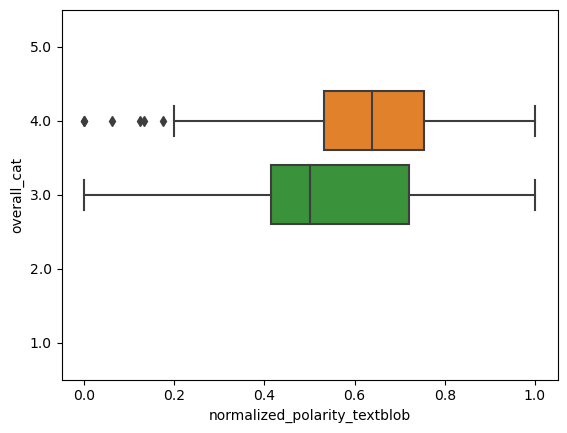

In [46]:
sns.boxplot(data=reviews, x="normalized_polarity_textblob", y="overall_cat", order=["5.0", "4.0", "3.0", "2.0", "1.0"])
plt.show()

### Comparing VADER and TextBlob

In [47]:
pearson_r, p_value = pearsonr(reviews["normalized_polarity_vader"],reviews["normalized_polarity_textblob"])
pearson_r

0.6589229516232069

<Axes: xlabel='normalized_polarity_vader', ylabel='normalized_polarity_textblob'>

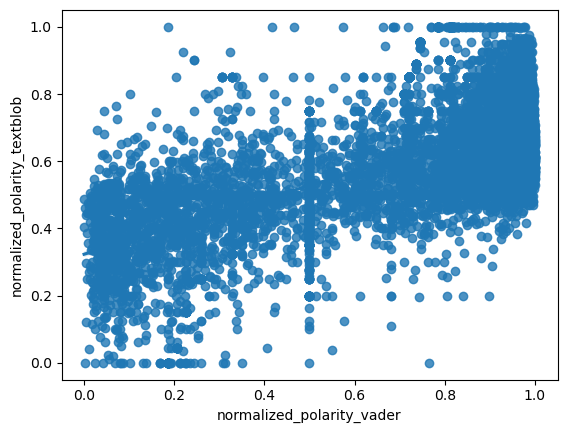

In [48]:
sns.regplot(data=reviews, x="normalized_polarity_vader", y="normalized_polarity_textblob")

In [49]:
reviews.describe()

,Zomato Score,content_polarity_vader,mean_sentence_polarity_vader,content_polarity_textblob,mean_sentence_polarity_textblob,normalized_score,normalized_polarity_vader,normalized_polarity_textblob
count,9955.000000,9955.000000,9955.000000,9.955000e+03,9955.000000,9955.000000,9955.000000,9955.000000
mean,3.600263,0.475257,0.275961,2.492011e-01,0.226977,0.483977,0.736976,0.624601
std,0.505936,0.585091,0.373486,3.644299e-01,0.336662,0.204007,0.293441,0.182215
min,2.400000,-0.994200,-0.972100,-1.000000e+00,-1.000000,0.000000,0.000000,0.000000
25%,3.230000,0.000000,0.000000,5.551115e-17,0.000000,0.334677,0.498621,0.500000
50%,3.610000,0.765000,0.318200,2.750000e-01,0.233510,0.487903,0.882291,0.637500
75%,3.845000,0.935900,0.503653,5.034524e-01,0.451181,0.582661,0.968002,0.751726
max,4.880000,0.999700,0.995000,1.000000e+00,1.000000,1.000000,1.000000,1.000000
